In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GRU
from tensorflow.keras.callbacks import History 

from wordcloud import WordCloud, STOPWORDS

In [ ]:
real=pd.read_excel('/content/sample_data/DataSetFinal.xlsx')
real.head()

NameError: ignored

In [ ]:
#Here Real= hate Data, Fake= Non-hate Data.
fake=pd.read_csv('/content/sample_data/Non-hate-Separate-Final.csv')
fake.head()

,sentence,hate,category
0,ভারতের ষড়যন্ত্রের শিকার সাকিববাংলাদেশ ক্রিকেট ...,non-hate,NaN
1,টিম ডংসো হইছে সাল থেকেওয়ার্ল্ড কাপে তার প্রমান...,non-hate,NaN
2,এক এক যুগে বাংলাদেশ একেকটা হিরোকে ধ্বংস করছে,non-hate,NaN
3,নটির পোলা পাপন সব তোর খেলা,non-hate,NaN
4,বাংলাদেশের মানুষ সবাই গর্জে ওঠো পাপনের বিরুদ্ধ...,non-hate,NaN


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create Target based on Real and Fake data
real['Geopolitical']          = 1
real['Religious']             = 2
real['Personal Hate']         = 3
real['Gender abusive hate']   = 4
fake['non-hate']              = 5


In [ ]:
print(real.shape)
real.head()

(4983, 6)


,text,label,Geopolitical,Religious,Personal Hate,Gender abusive hate
0,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,Geopolitical,1,2,3,4
1,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,Geopolitical,1,2,3,4
2,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,Religious,1,2,3,4
3,আমরা বলতে কারা ভারত তাইতো,Geopolitical,1,2,3,4
4,পাকিস্তান আমার বাল,Geopolitical,1,2,3,4


In [ ]:
print(fake.shape)
fake.head()

(20000, 4)


,sentence,hate,category,non-hate
0,ভারতের ষড়যন্ত্রের শিকার সাকিববাংলাদেশ ক্রিকেট ...,non-hate,NaN,5
1,টিম ডংসো হইছে সাল থেকেওয়ার্ল্ড কাপে তার প্রমান...,non-hate,NaN,5
2,এক এক যুগে বাংলাদেশ একেকটা হিরোকে ধ্বংস করছে,non-hate,NaN,5
3,নটির পোলা পাপন সব তোর খেলা,non-hate,NaN,5
4,বাংলাদেশের মানুষ সবাই গর্জে ওঠো পাপনের বিরুদ্ধ...,non-hate,NaN,5


In [ ]:
dataset = pd.concat([real, fake]).reset_index(drop=True)

In [ ]:
print(dataset.shape)
dataset.head()

(24983, 10)


,text,label,Geopolitical,Religious,Personal Hate,Gender abusive hate,sentence,hate,category,non-hate
0,ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...,Geopolitical,1.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN
1,রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে,Geopolitical,1.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN
2,এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...,Religious,1.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN
3,আমরা বলতে কারা ভারত তাইতো,Geopolitical,1.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN
4,পাকিস্তান আমার বাল,Geopolitical,1.0,2.0,3.0,4.0,NaN,NaN,NaN,NaN


In [ ]:
dataset.isnull().sum()

text                   20000
label                  20000
Geopolitical           20000
Religious              20000
Personal Hate          20000
Gender abusive hate    20000
sentence                4983
hate                   10682
category               19285
non-hate                4983
dtype: int64

In [ ]:
real['final_text'] = real['text'] + real['label']
real['final_text'].head()

0    ইনিই হচ্ছেন ভারতের প্রতিরক্ষামন্ত্রী মনোহর পা...
1     রেন্ডিয়াকে পৃথীবির মানচিএ থেকে মুচে ফেলতে হবে...
2    এই মালাউনরা বাংগালিদের সাফল্য দেখে হিংসা করে ব...
3               আমরা বলতে কারা ভারত তাইতো Geopolitical
4                      পাকিস্তান আমার বাল Geopolitical
Name: final_text, dtype: object

In [ ]:
real['label'].value_counts()

Geopolitical           1379
Personal                629
Political               592
Personal Hate           531
Religious               502
Gender abusive          316
Political Hate          200
Political Normal        200
Religious Hate          200
Geopoitical Hate        200
Gender abusive hate     200
Gender Abusive           30
Abusive                   3
Political                 1
Name: label, dtype: int64

In [ ]:
real[['label','Religious','Personal Hate']].groupby(['label','Personal Hate']).count()

,,Religious
label,Personal Hate,
Abusive,3,3
Gender Abusive,3,30
Gender abusive,3,316
Gender abusive hate,3,200
Geopoitical Hate,3,200
Geopolitical,3,1379
Personal,3,629
Personal Hate,3,531
Political,3,592


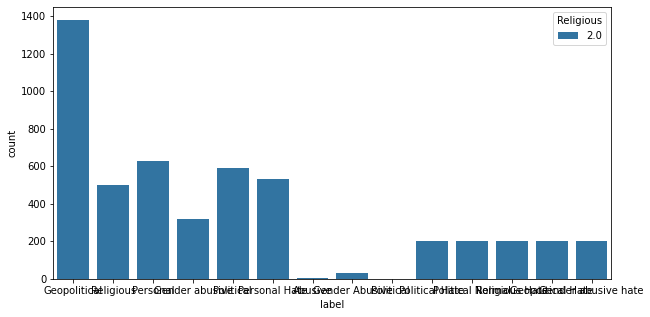

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x= "label", hue = "Religious", data=dataset)

In [ ]:
porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [ ]:
stemmed_text = []
lemmatized_text = []
final_text_result = []
for text in real['label']:
    result = re.sub('[^a-zA-Z]', ' ', text)
    result = result.lower()
    result = result.split()
    result = [r for r in result if r not in set(stopwords.words('english'))]
    final_text_result.append(" ".join(result))
    stemmed_result = [porter_stemmer.stem(r) for r in result]
    stemmed_text.append(" ".join(stemmed_result))
    lemmatized_result = [lemmatizer.lemmatize(r) for r in result]
    lemmatized_text.append(" ".join(lemmatized_result))

In [ ]:
print(len(final_text_result))
print(len(stemmed_text))
print(len(lemmatized_text))

4983
4983
4983


In [ ]:
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
plt.figure(figsize=(15,15))
wc=WordCloud(max_words=2000, width=1600, height=700, stopwords=STOPWORDS).generate("".join(real[fake.label==1].final_text))
plt.imshow(wc, interpolation="bilinear")



AttributeError: ignored

<Figure size 1080x1080 with 0 Axes>

In [ ]:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    print("Classification Report: \n", classification_report(y_test, y_pred))

In [ ]:
print("******USING STEMMED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(stemmed_text, real['label'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(), BernoulliNB(), LinearSVC(),
              KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

******USING STEMMED TEXT********


 LogisticRegression()
***********Usng Count Vectorizer****************
Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.00      0.94        81
Gender abusive hate       1.00      1.00      1.00        62
   Geopoitical Hate       1.00      1.00      1.00        59
       Geopolitical       1.00      1.00      1.00       404
           Personal       1.00      1.00      1.00       195
      Personal Hate       1.00      1.00      1.00       162
          Political       1.00      1.00      1.00       177
     Political Hate       1.00      1.00      1.00        57
   Political Normal       1.00      1.00      1.00        66
          Religious       1.00      1.00      1.00       155
     Religious Hate       1.00      1.00      1.00        66

           accuracy                           0.99      1495
          macro avg       0.91      0.92      0.92      14

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.00      0.94        81
Gender abusive hate       1.00      1.00      1.00        62
   Geopoitical Hate       1.00      1.00      1.00        59
       Geopolitical       1.00      1.00      1.00       404
           Personal       1.00      1.00      1.00       195
      Personal Hate       1.00      1.00      1.00       162
          Political       1.00      1.00      1.00       177
     Political Hate       1.00      1.00      1.00        57
   Political Normal       1.00      1.00      1.00        66
          Religious       1.00      1.00      1.00       155
     Religious Hate       1.00      1.00      1.00        66

           accuracy                           0.99      1495
          macro avg       0.84      0.85      0.84      14

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.00      0.94        81
Gender abusive hate       1.00      1.00      1.00        62
   Geopoitical Hate       1.00      1.00      1.00        59
       Geopolitical       1.00      1.00      1.00       404
           Personal       1.00      1.00      1.00       195
      Personal Hate       1.00      1.00      1.00       162
          Political       1.00      1.00      1.00       177
     Political Hate       1.00      1.00      1.00        57
   Political Normal       1.00      1.00      1.00        66
          Religious       1.00      1.00      1.00       155
     Religious Hate       1.00      1.00      1.00        66

           accuracy                           0.99      1495
          macro avg       0.84      0.85      0.84      14

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.00      0.94        81
Gender abusiv

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat


Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.00      0.94    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("******USING LEMMATIZED TEXT********")
X_train, X_test, y_train, y_test = train_test_split(lemmatized_text, real['label'], test_size = 0.3, random_state= 0)
classifiers = [LogisticRegression(), SGDClassifier(), MultinomialNB(), BernoulliNB(), LinearSVC(),
              KNeighborsClassifier(n_neighbors=5), DecisionTreeClassifier(), GradientBoostingClassifier(), 
               RandomForestClassifier(), XGBClassifier()]
for classifier in classifiers:
    print("\n\n", classifier)
    print("***********Usng Count Vectorizer****************")
    get_prediction(CountVectorizer(), classifier, X_train, X_test, y_train, y_test)
    print("***********Usng TFIDF Vectorizer****************")
    get_prediction(TfidfVectorizer(), classifier, X_train, X_test, y_train, y_test)

******USING LEMMATIZED TEXT********


 LogisticRegression()
***********Usng Count Vectorizer****************
Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.26
Confusion Matrix: 
 [[  0   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       0.00      0.00      0.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.88      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.00      0.94        81
Gender abusive hate       1.00      1.00      1.00        62
   Geopoitical Hate       1.00      1.00      1.00        59
       Geopolitical       1.00      1.00      1.00       404
           Personal       1.00      1.00      1.00       195
      Personal Hate       1.00      1.00      1.00       162
          Political       1.00      1.00      1.00       177
     Political Hate       1.00      1.00      1.00        57
   Political Normal       1.00      1.00      1.00        66
          Religious       1.00      1.00      1.00       155
     Religious Hate       1.00      1.00      1.00        66

           accuracy                           0.99      1495
          macro avg       0.91      0.92      0.92      14

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuarcy: 99.33
Confusion Matrix: 
 [[  1   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  10   0   0   0   0   0   0   0   0   0   0]
 [  0   0  81   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  62   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  59   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 404   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 195   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 177   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  57   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  66   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  66]]
Classification Report: 
                      precision    recall  f1-score   support

            Abusive       1.00      1.00      1.00         1
     Gender Abusive       0.00      0.00      0.00        10
     Gender abusive       0.89      1.0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.8.2


In [ ]:


from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping



In [ ]:


voc_size = 5000
onehot_stemmed_text = [one_hot(word, voc_size) for word in stemmed_text]
print(len(onehot_stemmed_text))
onehot_stemmed_text[0]



4983


[2411]

In [ ]:
sent_length = 400
embedded_text = pad_sequences(onehot_stemmed_text, padding='pre', maxlen=sent_length)
print(embedded_text)

[[   0    0    0 ...    0    0 2411]
 [   0    0    0 ...    0    0 2411]
 [   0    0    0 ...    0    0 2429]
 ...
 [   0    0    0 ... 4366 3343 3767]
 [   0    0    0 ... 4366 3343 3767]
 [   0    0    0 ... 4366 3343 3767]]


In [ ]:


embedding_vector_features = 600
model1 = Sequential()
model1.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 600)          3000000   
                                                                 
 lstm (LSTM)                 (None, 100)               280400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 3,280,501
Trainable params: 3,280,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_final = np.array(embedded_text)
y_final = real['label']

In [ ]:


X_final.shape,y_final.shape



((4983, 400), (4983,))

In [ ]:


X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)



In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='auto')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
import numpy as np

X_train = np.random.rand(1000,128,128,3)
y_train = np.random.rand(1000,2)
X_test = np.random.rand(200,128,128,3)
y_test = np.random.rand(200,2)

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
32/32 [==============================] - 54s 2s/step - loss: 7.4922 - accuracy: 0.5030 - val_loss: 5.9388 - val_accuracy: 0.5100
Epoch 2/10
32/32 [==============================] - 45s 1s/step - loss: 0.7078 - accuracy: 0.4890 - val_loss: 34.3586 - val_accuracy: 0.4900
Epoch 3/10
32/32 [==============================] - 47s 1s/step - loss: 0.6916 - accuracy: 0.4880 - val_loss: 75.5553 - val_accuracy: 0.4900
Epoch 4/10
32/32 [==============================] - 45s 1s/step - loss: 0.6915 - accuracy: 0.5050 - val_loss: 117.3198 - val_accuracy: 0.4900
Epoch 5/10
32/32 [==============================] - 46s 1s/step - loss: 0.6915 - accuracy: 0.5050 - val_loss: 156.0879 - val_accuracy: 0.4900
Epoch 6/10
32/32 [==============================] - 47s 1s/step - loss: 0.6915 - accuracy: 0.5050 - val_loss: 191.0175 - val_accuracy: 0.4900
Epoch 7/10
32/32 [==============================] - 45s 1s/step - loss: 0.6916 - accuracy: 0.5050 - val_loss: 220.4806 - val_accuracy: 0.4900
Epoch 8/10

In [ ]:
y_pred = (y_pred > 0.5) 
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

SyntaxError: ignored

In [ ]:


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: \n", cm)



In [ ]:
print("Classification Report: \n", classification_report(y_test, y_pred))

NameError: ignored

In [ ]:
voc_size = 5000
onehot_lemmatized_text = [one_hot(word, voc_size) for word in lemmatized_text]
print(len(onehot_lemmatized_text))
onehot_lemmatized_text[0]

4983


[235]

In [ ]:


sent_length = 400
embedded_text = pad_sequences(onehot_lemmatized_text, padding='pre', maxlen=sent_length)
print(embedded_text)



[[   0    0    0 ...    0    0  235]
 [   0    0    0 ...    0    0  235]
 [   0    0    0 ...    0    0 3823]
 ...
 [   0    0    0 ... 4366 3106 3767]
 [   0    0    0 ... 4366 3106 3767]
 [   0    0    0 ... 4366 3106 3767]]


In [ ]:


embedding_vector_features = 600
model2 = Sequential()
model2.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model2.add(LSTM(100))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 600)          3000000   
                                                                 
 lstm_1 (LSTM)               (None, 100)               280400    
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,280,501
Trainable params: 3,280,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:


X_final = np.array(embedded_text)
y_final = real['label']



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.3, random_state = 0)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
import numpy as np

X_train = np.random.rand(1000,128,128,3)
y_train = np.random.rand(1000,2)
X_test = np.random.rand(200,128,128,3)
y_test = np.random.rand(200,2)

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
32/32 [==============================] - 48s 2s/step - loss: 0.6900 - accuracy: 0.4790 - val_loss: 332.1277 - val_accuracy: 0.5200
Epoch 2/10
32/32 [==============================] - 46s 1s/step - loss: 0.6941 - accuracy: 0.5260 - val_loss: 345.9980 - val_accuracy: 0.5200
Epoch 3/10
32/32 [==============================] - 46s 1s/step - loss: 0.6908 - accuracy: 0.5140 - val_loss: 358.8437 - val_accuracy: 0.5200
Epoch 4/10
32/32 [==============================] - 48s 2s/step - loss: 0.6949 - accuracy: 0.4950 - val_loss: 320.4911 - val_accuracy: 0.5200
Epoch 5/10
32/32 [==============================] - 45s 1s/step - loss: 0.6900 - accuracy: 0.5170 - val_loss: 400.6061 - val_accuracy: 0.5200
Epoch 6/10
32/32 [==============================] - 48s 1s/step - loss: 0.7058 - accuracy: 0.5110 - val_loss: 245.6616 - val_accuracy: 0.5200
Epoch 7/10
32/32 [==============================] - 45s 1s/step - loss: 0.7516 - accuracy: 0.5030 - val_loss: 143.7535 - val_accuracy: 0.5200
Epoch 

In [ ]:
y_pred = model(X_test)
print("Accuarcy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))



TypeError: ignored

In [ ]:
import nltk
sentence_data = " নটির পোলা পাপন সব তোর খেলা 	 "
nltk_tokens = nltk.sent_tokenize(sentence_data)
print (nltk_tokens)

[' নটির পোলা পাপন সব তোর খেলা']


NameError: ignored

In [ ]:

tokenizer.fit_on_texts(X_train)


NameError: ignored

In [ ]:
import os
import csv
import spacy

class Corpus(object):

    def __init__(self, filename):
        self.filename = filename
        self.nlp = spacy.blank("en")
        
    def __iter__(self):
        with open(self.filename, "r") as i:
            reader = csv.reader(i, delimiter=",")
            for _, abstract in reader:
                tokens = [t.text.lower() for t in self.nlp(abstract)]
                yield tokens
                            
                    
documents = Corpus("data/arxiv/arxiv.csv")

In [ ]:
import gensim

model = gensim.models.Word2Vec(documents, min_count=100, window=5, vector_size=1000)

TypeError: ignored

In [ ]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [ ]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward0>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward0>))


In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("নটির পোলা পাপন সব তোর খেলা".split(), ["Religious", "Geopolitical", "Personal Hate", "Gender Abusive Hate", "Non-hate"]),
    ("পাকিস্তান আমার বাল".split(), ["Religious", "Geopolitical", "Personal Hate", "Gender Abusive Hate", "Non-hate"])
]
word_to_ix = {}
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index
print(word_to_ix)
tag_to_ix = {"Religious": 1, "Geopolitical": 2, "Personal Hate": 3, "Gender Abusive Hate":4, "Non-hate":5 }  # Assign each tag with a unique index

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'নটির': 0, 'পোলা': 1, 'পাপন': 2, 'সব': 3, 'তোর': 4, 'খেলা': 5, 'পাকিস্তান': 6, 'আমার': 7, 'বাল': 8}


In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
 model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tensor([[-1.6626, -1.4556, -1.8148, -1.5270, -1.6244],
        [-1.6212, -1.4641, -1.8199, -1.5572, -1.6181],
        [-1.6455, -1.4557, -1.8113, -1.5511, -1.6174],
        [-1.6043, -1.4108, -1.7987, -1.5435, -1.7380],
        [-1.4968, -1.4768, -1.8415, -1.6091, -1.6652],
        [-1.5315, -1.4676, -1.8506, -1.5811, -1.6585]])


ValueError: ignored

In [ ]:
#####################################


import numpy as np
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Non-hate-Separate-Final.csv')
real=pd.read_excel('/content/sample_data/DataSetFinal.xlsx')

data

In [ ]:
import numpy as np
print("Hatred labeled: {}\nNon-hatred labeled: {}".format(
    (data.label == 1).sum(),
    (data.label == 0).sum()
))